<a href="https://colab.research.google.com/github/gayecolakoglu/Malaria_Detection_Deep_Learning/blob/main/ResNet50_Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# GET DATA FROM KAGGLE

In [ ]:
#install kaggle API and make a directory called kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

#import the API key into colab
from google.colab import files
files.upload()

#copy the API key to the kaggle directory we created
!cp kaggle.json ~/.kaggle/

#list the datasets with this code
!kaggle datasets list

#download files now by using this sample code
!kaggle datasets download -diarunava/cell-images-for-detecting-malaria
!ls

Saving kaggle.json to kaggle.json
ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                   5MB  2022-11-13 15:47:17          11111        326  1.0              
michals22/coffee-dataset                                        Coffee dataset                                    24KB  2022-12-15 20:02:12           2016         58  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                  3MB  2022-11-16 13:52:31           6958        150  1.0              
thedevastator/unlock-profits-with-e-comme

# UNZİP DATA

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/cell-images-for-detecting-malaria.zip", 'r')
zip_ref.extractall("/content/gdrive/MyDrive/Colab Notebooks/ML")
zip_ref.close()

In [ ]:
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images/"
data_dir = pathlib.Path(data_dir)

parasited_count = len(list(data_dir.glob('Parasitized/*.png')))
print("Parasited:",parasited_count)

uninfected_count = len(list(data_dir.glob('Uninfected/*.png')))
print("Uninfected:",uninfected_count)

Parasited: 13779
Uninfected: 13779


In [ ]:
#this directory contains same data, we can delete it
import shutil

shutil.rmtree('/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images/cell_images')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [ ]:
print(os.listdir("/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images/"))

['Parasitized', 'Uninfected']


data analisi yap balance mı değil mi kontrol et grafiklerle

In [ ]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [ ]:
img_dir='/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images'
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, 
    sampler=test_sampler, num_workers=num_workers)

5511 2756 19291


# Model ResNet50

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

# Training The Network

In [ ]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
train(25, model, optimizer, criterion, use_cuda, 'malaria_detection.pt')

Epoch 1, Batch 1 loss: 0.643121
Epoch 1, Batch 101 loss: 0.520724
Epoch 1, Batch 201 loss: 0.468598
Epoch 1, Batch 301 loss: 0.452917
Epoch: 1 	Training Loss: 0.452775 	Validation Loss: 0.384746
Validation loss decreased (inf --> 0.384746).  Saving model ...
Epoch 2, Batch 1 loss: 0.553508
Epoch 2, Batch 101 loss: 0.385761
Epoch 2, Batch 201 loss: 0.379321
Epoch 2, Batch 301 loss: 0.382629
Epoch: 2 	Training Loss: 0.382585 	Validation Loss: 0.374145
Validation loss decreased (0.384746 --> 0.374145).  Saving model ...
Epoch 3, Batch 1 loss: 0.292662
Epoch 3, Batch 101 loss: 0.382990
Epoch 3, Batch 201 loss: 0.375591
Epoch 3, Batch 301 loss: 0.374013
Epoch: 3 	Training Loss: 0.373669 	Validation Loss: 0.370620
Validation loss decreased (0.374145 --> 0.370620).  Saving model ...
Epoch 4, Batch 1 loss: 0.291693
Epoch 4, Batch 101 loss: 0.356882
Epoch 4, Batch 201 loss: 0.365329
Epoch 4, Batch 301 loss: 0.367397
Epoch: 4 	Training Loss: 0.367358 	Validation Loss: 0.353417
Validation loss de

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Loading Saved Model

In [ ]:
model.load_state_dict(torch.load('malaria_detection.pt'))

<All keys matched successfully>

# Testing The Model

In [ ]:
def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion, use_cuda)

Test Loss: 0.334181


Test Accuracy: 85% (2353/2756)


# Writing The Algorithm for Code Execution

In [ ]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

Parasitized


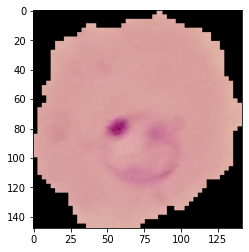

Uninfected


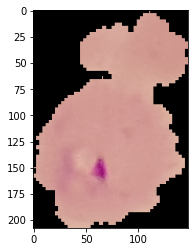

Parasitized


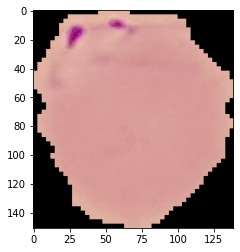

Uninfected


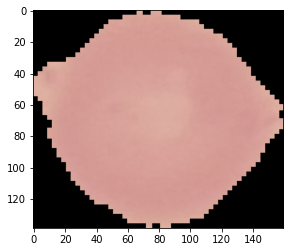

Uninfected


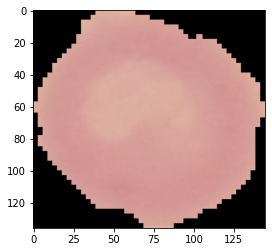

Uninfected


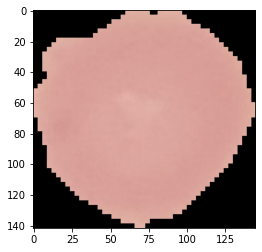

In [ ]:
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']
inf = np.array(glob("/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images/Parasitized/*"))
uninf = np.array(glob("/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images/Uninfected/*"))
for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()